In [2]:
!pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import yfinance as yf

msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

In [4]:
import os
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

In [5]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055536,0.063703,0.055536,0.060980,1031788800,0.0,0.0
1986-03-14,0.060980,0.064247,0.060980,0.063158,308160000,0.0,0.0
1986-03-17,0.063158,0.064792,0.063158,0.064247,133171200,0.0,0.0
1986-03-18,0.064247,0.064792,0.062069,0.062613,67766400,0.0,0.0
1986-03-19,0.062613,0.063158,0.060980,0.061524,47894400,0.0,0.0


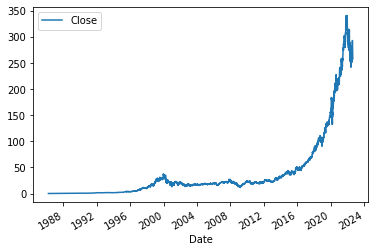

In [6]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [7]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]


In [8]:
data.head()

,Actual_Close,Target
Date,,
1986-03-13,0.060980,NaN
1986-03-14,0.063158,1.0
1986-03-17,0.064247,1.0
1986-03-18,0.062613,0.0
1986-03-19,0.061524,0.0


In [9]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [10]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055536,0.063703,0.055536,0.060980,1.031789e+09,0.0,0.0
1986-03-17,0.060980,0.064247,0.060980,0.063158,3.081600e+08,0.0,0.0
1986-03-18,0.063158,0.064792,0.063158,0.064247,1.331712e+08,0.0,0.0
1986-03-19,0.064247,0.064792,0.062069,0.062613,6.776640e+07,0.0,0.0


In [11]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [12]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14,0.063158,1.0,0.060980,1.031789e+09,0.055536,0.063703,0.055536
1986-03-17,0.064247,1.0,0.063158,3.081600e+08,0.060980,0.064247,0.060980
1986-03-18,0.062613,0.0,0.064247,1.331712e+08,0.063158,0.064792,0.063158
1986-03-19,0.061524,0.0,0.062613,6.776640e+07,0.064247,0.064792,0.062069
1986-03-20,0.059891,0.0,0.061524,4.789440e+07,0.062613,0.063158,0.060980


In [14]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

In [16]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [17]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5

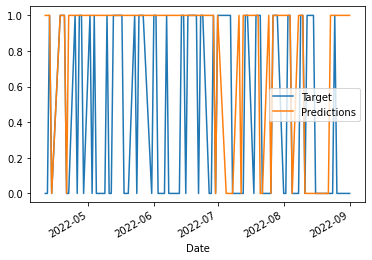

In [18]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [19]:
i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

In [20]:
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

In [21]:
preds.head()

Date
1990-02-27    1.0
1990-02-28    1.0
1990-03-01    1.0
1990-03-02    1.0
1990-03-05    1.0
dtype: float64

In [22]:
predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

In [23]:
predictions[0].head()

,Target,Predictions
Date,,
1990-02-27,0.0,1.0
1990-02-28,1.0,1.0
1990-03-01,1.0,1.0
1990-03-02,1.0,1.0
1990-03-05,1.0,1.0


In [24]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)


In [25]:
predictions = backtest(data, model, predictors)

In [26]:
predictions["Predictions"].value_counts()

0.0    7450
1.0     743
Name: Predictions, dtype: int64

In [27]:
predictions["Target"].value_counts()

1.0    4149
0.0    4044
Name: Target, dtype: int64

In [28]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4979811574697174

In [29]:
weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

In [30]:
weekly_trend = data.shift(1).rolling(7).sum()["Target"]

In [31]:
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

In [33]:
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]


In [34]:
data["weekly_trend"] = weekly_trend

In [35]:
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [39]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [40]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6086956521739131

In [41]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    7575
1.0     253
Name: Predictions, dtype: int64

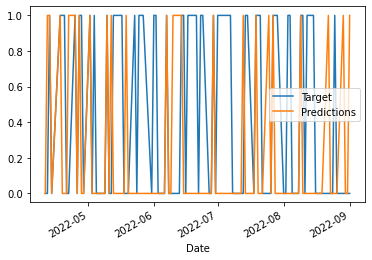

In [42]:
# Look at trades we would have made in the last 100 days

predictions.iloc[-100:].plot()